In [1]:
import numpy as np 
import pandas as pd
import random

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import cross_validation
from sklearn import tree
from IPython.display import Image
import pickle,os,pydot

import h2o

In [2]:
h2o.init()



No instance found at ip and port: localhost:54321. Trying to start local jar...


JVM stdout: c:\cygwin64\tmp\tmpc11oj5\h2o_Robert_started_from_python.out
JVM stderr: c:\cygwin64\tmp\tmpmi4zif\h2o_Robert_started_from_python.err
Using ice_root: c:\cygwin64\tmp\tmpbibmvm


Java Version: java version "1.8.0_91"
Java(TM) SE Runtime Environment (build 1.8.0_91-b15)
Java HotSpot(TM) 64-Bit Server VM (build 25.91-b15, mixed mode)


Starting H2O JVM and connecting: ...... Connection sucessful!


C:\Users\Robert\Anaconda2\lib\site-packages\IPython\core\formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
C:\Users\Robert\Anaconda2\lib\site-packages\IPython\core\formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


H2O cluster uptime:,10 seconds 143 milliseconds
H2O cluster version:,3.2.0.9
H2O cluster name:,H2O_started_from_python
H2O cluster total nodes:,1
H2O cluster total memory:,1.76 GB
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster healthy:,True
H2O Connection ip:,127.0.0.1
H2O Connection port:,54321


In [3]:
path_1= 'bitbootcamp/winequality-white.csv'
path_2 = 'bitbootcamp/winequality-red.csv'

In [4]:
df = pd.concat([pd.read_csv(path_1,sep=';'),pd.read_csv(path_2,sep=';')])

In [5]:
len(df)

6497

In [6]:
def quality(row):
    if row['quality']>=6:
        return 1
    else:
        return 0

In [7]:
df['quality']=df.apply(quality,axis=1)

In [8]:
df['quality']=df['quality'].astype('category')

In [9]:
df.to_csv('bitbootcamp/winequality.csv',sep=';')

In [10]:
del df

In [ ]:
file_path='bitbootcamp/winequality.csv'

In [ ]:
params_load_data={'path': file_path,
                 'destination_frame': 'data.hex',
                 'header': 1,
                 'sep': ';'}
data_hex = h2o.import_file(**params_load_data)

In [13]:
response=unicode('quality')

In [14]:
data_hex[response]=data_hex[response].asfactor()

In [15]:
features=data_hex.names

for idx, feature in enumerate(features):
    if feature == response:
        idx_response=idx

In [16]:
num_features_all = len(features)

In [17]:
features.remove(response)

num_features=len(features)

In [18]:
print num_features_all
print num_features

13
12


In [19]:
random_idx=data_hex[idx_response].runif(seed=1234)

In [20]:
train_hex=data_hex[random_idx<0.7]
test_hex=data_hex[random_idx>=0.7]

In [21]:
temp_df = data_hex.as_data_frame()

num_false=temp_df.iloc[:,idx_response].value_counts()[0]
num_true=temp_df.iloc[:,idx_response].value_counts()[1]

del temp_df

ratio_true=float(num_true)/(num_false+num_true)

print round(ratio_true,3)

0.633


In [22]:
temp_df_train=train_hex.as_data_frame()
temp_df_test=test_hex.as_data_frame()

num_false_train=temp_df_train.iloc[:,idx_response].value_counts()[0]
num_false_test=temp_df_test.iloc[:,idx_response].value_counts()[0]

num_true_train=temp_df_train.iloc[:,idx_response].value_counts()[1]
num_true_test=temp_df_test.iloc[:,idx_response].value_counts()[1]

del temp_df_train, temp_df_test

ratio_true_train=float(num_true_train)/(num_true_train+num_false_train)
ratio_true_test=float(num_true_test)/(num_true_test+num_false_test)

print round(ratio_true_train,3)
print round(ratio_true_test,3)

0.631
0.638


In [23]:
#Decision tree
df_train=train_hex.as_data_frame()
df_test=train_hex.as_data_frame()

range_depth = np.arange(1,5,1)
#Not sure what this range depends on
range_leaf_samples = np.arange(50,150,10)

num_sampling=100

opt_score=0
opt_depth=0
opt_leaf_samples=0

In [24]:
#Use features[1:] since the dataframe seems to have creatred another column for index
features=features[1:]

In [25]:
for id_sample, sample in enumerate(range(num_sampling)):
    depth=random.sample(range_depth,1)[0]
    leaf_samples=random.sample(range_leaf_samples,1)[0]
    split_samples=random.sample(range_leaf_samples,1)[0]
    
    params_model={'max_depth':depth,'min_samples_leaf':leaf_samples,'min_samples_split':split_samples,'criterion':'gini'}
    dt_model=DecisionTreeClassifier(**params_model)
    
    
    params_cross_val= {'estimator':dt_model,'X':df_train[features],'y':df_train[response],'cv':3}
    scores=cross_validation.cross_val_score(**params_cross_val)
    score_mean=scores.mean()
    
    if score_mean>opt_score:
        opt_score=score_mean
        opt_depth=depth
        opt_leaf_samples=leaf_samples
        
print 'optimal score: '+str(round(opt_score,3))
print 'optimal depth : '+str(opt_depth)
print 'optimal leaf_samples: '+str(opt_leaf_samples)

optimal score: 0.71
optimal depth : 4
optimal leaf_samples: 70


depth : 4 leaf_samples : 70


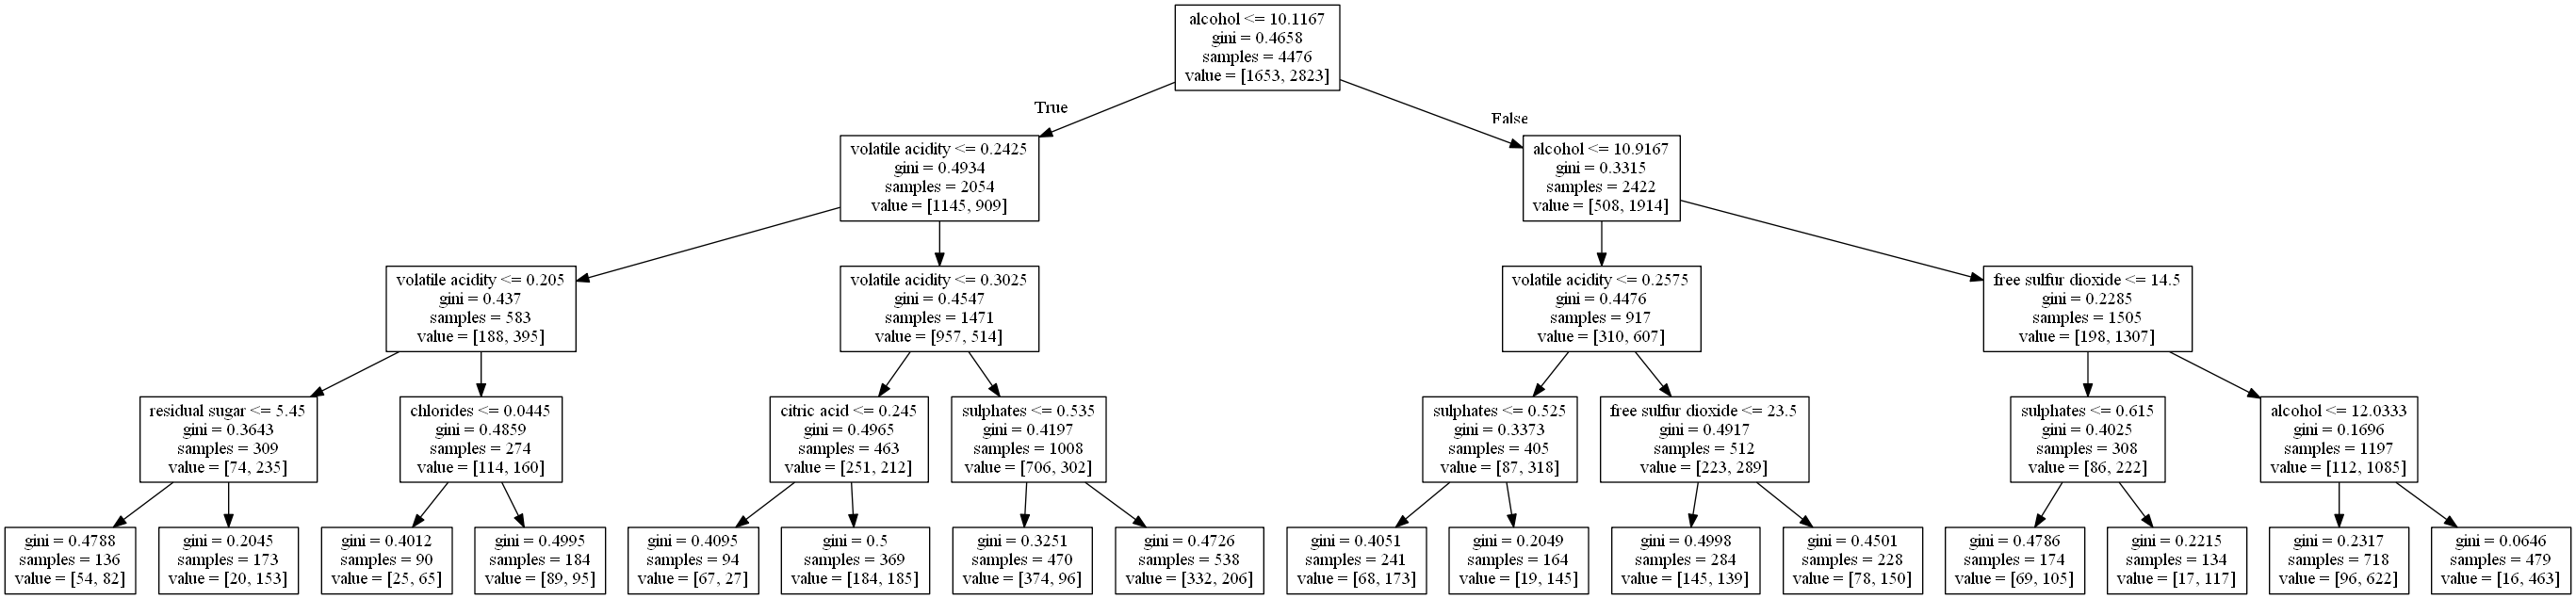

In [26]:
params_model_opt={'max_depth':opt_depth,'min_samples_leaf':opt_leaf_samples,'criterion':'gini'}
params_fitting={'X':df_test[features],'y':df_test[response]}
opt_dt_model=DecisionTreeClassifier(**params_model_opt).fit(**params_fitting)

dic_tree_graph={'decision_tree':opt_dt_model,'out_file':'dot_data.dot','feature_names':features}
tree.export_graphviz(**dic_tree_graph)

graph=pydot.graph_from_dot_file('dot_data.dot')
os.remove('dot_data.dot')

print 'depth : '+str(opt_depth)+ ' leaf_samples : '+str(opt_leaf_samples)
Image(graph.create_png())

In [27]:
params_predict={'X':df_test[features]}
y_predict=opt_dt_model.predict(**params_predict)

y_probab=opt_dt_model.predict_proba(**params_predict)[:,1]

In [28]:
y_actual=df_test[response].values
fpr1,tpr1, _ = metrics.roc_curve(y_actual,y_probab)

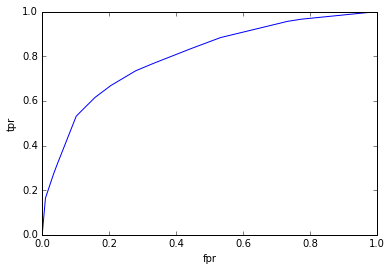

In [29]:
plt.plot(fpr1,tpr1)
plt.xlabel('fpr')
plt.ylabel('tpr')

In [30]:
auc1 = metrics.roc_auc_score(y_actual,y_predict)
print 'AUC value: '+str(round(auc1,3))

AUC value: 0.695


In [31]:
#Random forest
random_idx=train_hex[idx_response].runif()

train_holdout_hex=train_hex[random_idx<0.8]
validation_holdout_hex=train_hex[random_idx>=0.8]

In [32]:
range_ntrees=np.arange(500,1000,100)
range_depth=np.arange(2,4,1)
range_min_rows=np.arange(10,20,1)

num_models=10

In [33]:
rf_models=[]

for id_model in range(num_models):
    
    ntree=random.sample(range_ntrees,1)[0]
    depth=random.sample(range_depth,1)[0]
    min_rows=random.sample(range_min_rows,1)[0]
    
    params_model={'x':features,
                 'y':response,
                 'training_frame':train_holdout_hex,
                 'validation_frame':validation_holdout_hex,
                 'ntrees':ntree,
                 'max_depth':depth,
                 'min_rows':min_rows,
                 'mtries':-1}
    rf_model=h2o.random_forest(**params_model)
    
    rf_models.append(rf_model)


drf Model Build Progress: [##################################################] 100%

drf Model Build Progress: [##################################################] 100%

drf Model Build Progress: [##################################################] 100%

drf Model Build Progress: [##################################################] 100%

drf Model Build Progress: [##################################################] 100%

drf Model Build Progress: [##################################################] 100%

drf Model Build Progress: [##################################################] 100%

drf Model Build Progress: [##################################################] 100%

drf Model Build Progress: [##################################################] 100%

drf Model Build Progress: [##################################################] 100%


In [34]:
best_auc=0
for id_model,model in enumerate(rf_models):
    auc=model.auc(valid=True)
    
    if auc>best_auc:
        best_auc=auc
        best_auc_id=id_model
        
best_model=rf_models[best_auc_id]

In [35]:
list_model_params=list(best_model.params.keys())
bmps=best_model.params.items()

best_ntree=bmps[list_model_params.index('ntrees')][1]['actual']
best_depth=bmps[list_model_params.index('max_depth')][1]['actual']
best_min_rows=bmps[list_model_params.index('min_rows')][1]['actual']

In [36]:
params_best_model={'x':features,
                  'y':response,
                  'training_frame':train_hex,
                  'validation_frame':test_hex,
                  'ntrees':best_ntree,
                  'max_depth':best_depth,
                  'min_rows':best_min_rows,
                  'mtries':-1}
rebuild_rf_model=h2o.random_forest(**params_best_model)


drf Model Build Progress: [##################################################] 100%


In [37]:
print 'optimal ntrees : ' + str(best_ntree)
print 'optimal max_depth : ' + str(best_depth)
print 'optimal min_rows : ' + str(best_min_rows)

optimal ntrees : 800
optimal max_depth : 3
optimal min_rows : 15.0


In [38]:
rebuild_roc=rebuild_rf_model.roc(valid=True)

tpr=rebuild_roc[0]
fpr=rebuild_roc[1]

0.813


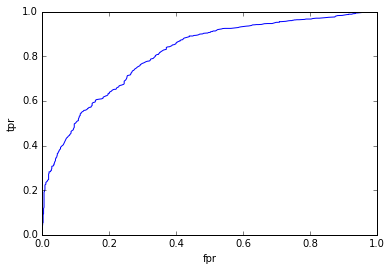

In [39]:
plt.plot(tpr,fpr)
plt.xlabel('fpr')
plt.ylabel('tpr')

rebuild_auc=rebuild_rf_model.model_performance(valid=True).auc()

print round(rebuild_auc,3)

In [40]:
gbm_models=[]

for id_model in range(num_models):
    
    ntree=random.sample(range_ntrees,1)[0]
    depth=random.sample(range_depth,1)[0]
    min_rows=random.sample(range_min_rows,1)[0]
    
    params_model={'x':features,
                 'y':response,
                 'training_frame':train_holdout_hex,
                 'validation_frame':validation_holdout_hex,
                 'ntrees':ntree,
                 'max_depth':depth,
                 'learn_rate':0.01}
    gbm_model=h2o.gbm(**params_model)
    
    gbm_models.append(gbm_model)


gbm Model Build Progress: [##################################################] 100%

gbm Model Build Progress: [##################################################] 100%

gbm Model Build Progress: [##################################################] 100%

gbm Model Build Progress: [##################################################] 100%

gbm Model Build Progress: [##################################################] 100%

gbm Model Build Progress: [##################################################] 100%

gbm Model Build Progress: [##################################################] 100%

gbm Model Build Progress: [##################################################] 100%

gbm Model Build Progress: [##################################################] 100%

gbm Model Build Progress: [##################################################] 100%


In [41]:
best_auc=0

for id_model,model in enumerate(gbm_models):
    auc=model.auc(valid=True)
    
    if auc>best_auc:
        best_auc=auc
        best_auc_id=id_model
        
best_model=gbm_models[best_auc_id]

In [42]:
list_model_params=list(best_model.params.keys())
bmps=best_model.params.items()

best_ntree=bmps[list_model_params.index('ntrees')][1]['actual']
best_depth=bmps[list_model_params.index('max_depth')][1]['actual']
best_min_rows=bmps[list_model_params.index('min_rows')][1]['actual']

In [43]:
print 'optimal ntrees : ' + str(best_ntree)
print 'optimal max_depth : ' + str(best_depth)
print 'optimal min_rows : ' + str(best_min_rows)

optimal ntrees : 900
optimal max_depth : 3
optimal min_rows : 10.0


In [44]:
params_best_model={'x':features,
                  'y':response,
                  'training_frame':train_hex,
                  'validation_frame':test_hex,
                  'ntrees':best_ntree,
                  'max_depth':best_depth,
                  'min_rows':best_min_rows,
                  'learn_rate':0.01}
rebuild_gbm_model=h2o.gbm(**params_best_model)


gbm Model Build Progress: [##################################################] 100%


In [45]:
rebuild_roc=rebuild_gbm_model.roc(valid=True)

tpr=rebuild_roc[0]
fpr=rebuild_roc[1]

0.847


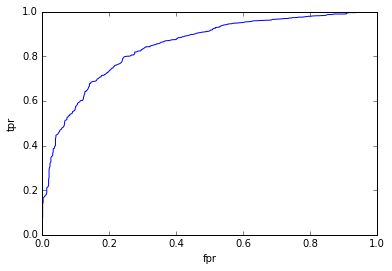

In [46]:
plt.plot(tpr,fpr)
plt.xlabel('fpr')
plt.ylabel('tpr')

rebuild_auc=rebuild_gbm_model.model_performance(valid=True).auc()

print round(rebuild_auc,3)

gbm auc : 0.847
rf auc : 0.813
decision tree auc : 0.695


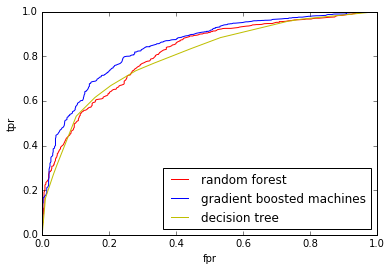

In [47]:
#These two are labeled incorrectly
plt.plot(rebuild_rf_model.roc(valid=True)[0],rebuild_rf_model.roc(valid=True)[1],'r')
plt.plot(rebuild_gbm_model.roc(valid=True)[0],rebuild_gbm_model.roc(valid=True)[1],'b')
#Strange, they're switched here
plt.plot(fpr1,tpr1,'y')

plt.xlabel('fpr')
plt.ylabel('tpr')

plt.legend(['random forest','gradient boosted machines','decision tree'],loc='lower right')

print 'gbm auc : ' + str(round(rebuild_auc,3))
print 'rf auc : ' + str(round(rebuild_rf_model.model_performance(valid=True).auc(),3))
print 'decision tree auc : '+ str(round(auc1,3))